In [2]:
"""
ENGD Optimization.
Two dimensional Poisson equation example. Solution given by

u(x,y) = sin(pi*x) * sin(py*y).

"""
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit

from ngrad.models import init_params, mlp
from ngrad.domains import Square, SquareBoundary
from ngrad.integrators import DeterministicIntegrator
from ngrad.utility import laplace, grid_line_search_factory
from ngrad.inner import model_laplace, model_identity
from ngrad.gram import gram_factory, nat_grad_factory

jax.config.update("jax_enable_x64", True)

tau = 1.

# random seed
seed = 0

# domains
interior = Square(1.)
boundary = SquareBoundary(1.)

# integrators
interior_integrator = DeterministicIntegrator(interior, 30)
boundary_integrator = DeterministicIntegrator(boundary, 30)
eval_integrator = DeterministicIntegrator(interior, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = init_params(layer_sizes, random.PRNGKey(seed))
model = mlp(activation)
# v_model = vmap(model, (None, 0))
v_model = vmap(lambda params, x: model(params, x), (None, 0))

# solution
@jit
def u_star(x):
    return jnp.prod(jnp.sin(jnp.pi * x))

# rhs
@jit
def f(x):
    return 2. * jnp.pi**2 * u_star(x)

# gramians
gram_bdry = gram_factory(
    model = model,
    trafo = model_identity,
    integrator = boundary_integrator
)

gram_laplace = gram_factory(
    model = model,
    trafo = model_laplace,
    integrator = interior_integrator
)

@jit
def gram(params):
    return gram_laplace(params) + gram_bdry(params)

# natural gradient
nat_grad = nat_grad_factory(gram)

# compute residual
laplace_model = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (laplace_model(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    return tau * boundary_integrator(lambda x: v_model(params, x)**2)

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# set up grid line search
grid = jnp.linspace(0, 30, 31)
steps = 0.5**grid
ls_update = grid_line_search_factory(loss, steps)

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(
        lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5
        )

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5    


iterations = 500
save_freq = 10

import numpy as np
data = np.empty((iterations // save_freq + 1, 5))

# natural gradient descent with line search
for iteration in range(iterations + 1):
    interior_grads = grad(interior_loss)(params)
    interior_nat_grads = nat_grad(params, interior_grads)
    
    boundary_grads = grad(boundary_loss)(params)
    boundary_nat_grads = nat_grad(params, boundary_grads)
    
    updates = jax.tree_util.tree_map(lambda i, b: (i + b) / 2, interior_nat_grads, boundary_nat_grads)
    
    params, actual_step = ls_update(params, updates)
    
    if iteration % save_freq == 0:
        # errors
        l2_error = l2_norm(v_error, eval_integrator)
        h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)
        
        data[iteration // save_freq, :] = [
            iteration,
            interior_loss(params),
            boundary_loss(params),
            l2_error,
            h1_error,
        ]
    
        print(
            f'ENGD Iteration: {iteration}'
            f'\n  with loss: {interior_loss(params)} + {boundary_loss(params)} = {loss(params)}'
            f'\n  with error L2: {l2_error} and error H1: {h1_error}'
            f'\n  with step: {actual_step}'
        )
        
jnp.save("data/multi-engd.npy", data)


ENGD Iteration: 0
  with loss: 39.24738553705797 + 7.034491660034821 = 46.2818771970928
  with error L2: 1.0328661563755408 and error H1: 3.4218235390839005
  with step: 3.814697265625e-06
ENGD Iteration: 10
  with loss: 12.284821168131128 + 3.050744992997774 = 15.335566161128902
  with error L2: 0.6461249853539451 and error H1: 2.721002042944454
  with step: 0.015625
ENGD Iteration: 20
  with loss: 0.1351466704961914 + 0.033965031610638866 = 0.16911170210683024
  with error L2: 0.07654762155352376 and error H1: 0.30427206416188934
  with step: 0.5
ENGD Iteration: 30
  with loss: 1.2951180575477775e-06 + 3.3954999953616835e-07 = 1.6346680570839459e-06
  with error L2: 0.0002762310774082693 and error H1: 0.0007223155329366233
  with step: 0.06249999999999999
ENGD Iteration: 40
  with loss: 1.1299532008576025e-06 + 3.336610827630512e-07 = 1.4636142836206537e-06
  with error L2: 0.00027065379881059144 and error H1: 0.0007228181327901416
  with step: 0.015625
ENGD Iteration: 50
  with loss

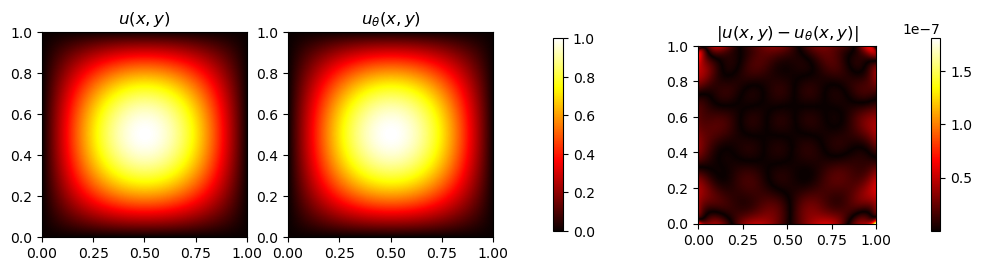

In [3]:
from util import save


n = 300
save("multi-engd", n, u_star, v_model, params)